<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Cleaning of data
LotFrontage: Replace NaN with zero  

**replace Nan in LotFrontage with mean or median instead and include a column to indicate the NaN rows**  

Alley: Replace NaN with 'NoAcc'  
MasVnrType: Replace NaN (only 8 rows) with 'None' (majority class)  
MasVnrArea: Replace NaN (only 8 rows) with zero (majority class)  
BsmtQual: Replace NaN with 'NoBsmt'  
BsmtCond: Replace NaN with 'NoBsmt'  
BsmtExposure: Replace NaN with 'NoBsmt'  
BsmtFinType1: Replace NaN with 'NoBsmt'  
BsmtFinType2: Replace NaN with 'NoBsmt'  
Electrical: Replace only NaN value with 'SBrkr' (majority class)  
FireplaceQu: Replace NaN with 'NoFirepl'  
GarageType: Replace NaN with 'NoGarage'  
GarageYrBlt: Replace NaN with value of column YearBuilt  
GarageFinish: Replace NaN with 'NoGarage'  
GarageQual: Replace NaN with 'NoGarage'  
GarageCond: Replace NaN with 'NoGarage'  
PoolQC: Replace NaN with 'NoPool'  
Fence: Replace NaN with 'NoFence'  
MiscFeature: Replace NaN with 'None'  

In [4]:
for col in ['LotFrontage', 'MasVnrArea']:
    house.loc[house[col].isnull(), col] = 0

In [5]:
house.loc[house['Alley'].isnull(), 'Alley'] = 'NoAcc'
house.loc[house['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

In [6]:
house[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = \
house[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna(value='NoBsmt')

In [7]:
house.loc[house['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
house.loc[house['FireplaceQu'].isnull(), 'FireplaceQu'] = 'NoFirepl'

In [8]:
house[['GarageType','GarageFinish','GarageQual','GarageCond']] = \
house[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna(value='NoGarage')

In [9]:
house.loc[house['GarageYrBlt'].isnull(), 'GarageYrBlt'] = house.loc[house['GarageYrBlt'].isnull(), 'YearBuilt']
house['GarageYrBlt'] = house['GarageYrBlt'].astype('int')

In [10]:
house.loc[house['PoolQC'].isnull(),'PoolQC'] = 'NoPool'
house.loc[house['Fence'].isnull(),'Fence'] = 'NoFence'
house.loc[house['MiscFeature'].isnull(),'MiscFeature'] = 'None'

from Chenghan

Selected the following as "Fixed" predictors:  
MSSubClass  
MSZoning  
LotFrontage  
LotArea  
Street  
Alley  
LotShape  
LandContour  
LotConfig  
LandSlope  
Neighborhood  
Condition1  
Condition2  
BldgType   
HouseStyle   
YearBuilt  
YearRemodAdd  
Foundation  
BsmtQual  
BsmtFinSF1  
BsmtFinSF2  
BsmtUnfSF  
TotalBsmtSF  
1stFlrSF  
2ndFlrSF  
LowQualFinSF  
GrLivArea  
BsmtFullBath  
BsmtHalfBath  
FullBath  
HalfBath  
BedroomAbvGr  
KitchenAbvGr  
TotRmsAbvGrd  
Fireplaces  
GarageType  
GarageYrBlt  
GarageCars  
GarageArea  

In [64]:
# Creating a list of the 'Fixed' characteristics
cols = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','LotConfig',\
        'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd',\
        'Foundation','BsmtQual','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
        'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
        'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea']

In [65]:
# Copying the columns with fixed characteristics into a new dataframe
df1 = house[cols].copy()

Notes by Chenghan

Convert column "MSSubClass" to the following dummy variables:

(20, 30) -> 1S_New (1, 0)  
(40)     -> 1S_Attic (1, 0)  
(45, 50) -> 1_5S_Fin (0, 1)  
(60, 70) -> 2S_New (1, 0)  
(75)     -> 2_5S (1, 0)  
(80)     -> M_Lvl (1, 0)  
(85)     -> SplitFoyer (1, 0)  
(90)     -> Duplex (1, 0)  
(120)    -> 1S_PUD (1, 0)  
(150)    -> 1_5S_PUD (1, 0) [no values in this category]  
(160)    -> 2S_PUD (1, 0)  
(180)    -> M_Lvl_PUD (1, 0)  
(190)    -> 2_Fam (1, 0)  

Column "MSZoning" - verified that non-residential zones are already excluded

In [66]:
# Converting all columns with categorical values into binary columns
df1.loc[df1['MSSubClass']==20,'MS_1S_New'] = 1
df1.loc[df1['MSSubClass']==30,'MS_1S_New'] = 0
df1.loc[df1['MSSubClass']==40,'MS_1S_Attic'] = 1
df1.loc[df1['MSSubClass']==45,'MS_1_5S_Fin'] = 0
df1.loc[df1['MSSubClass']==50,'MS_1_5S_Fin'] = 1
df1.loc[df1['MSSubClass']==60,'MS_2S_New'] = 1
df1.loc[df1['MSSubClass']==70,'MS_2S_New'] = 0
df1.loc[df1['MSSubClass']==75,'MS_2_5S'] = 1
df1.loc[df1['MSSubClass']==80,'MS_M_Lvl'] = 1
df1.loc[df1['MSSubClass']==85,'MS_SplitFoyer'] = 1
df1.loc[df1['MSSubClass']==90,'MS_Duplex'] = 1
df1.loc[df1['MSSubClass']==120,'MS_1S_PUD'] = 1
df1.loc[df1['MSSubClass']==160,'MS_2S_PUD'] = 1
df1.loc[df1['MSSubClass']==180,'MS_M_Lvl_PUD'] = 1
df1.loc[df1['MSSubClass']==190,'MS_2_Fam'] = 1

In [67]:
df1.fillna(value=0, inplace=True)
df1 = df1.drop(columns='MSSubClass')

In [68]:
# Create a dictionary of variable and the dummy prefix
fixed_cat = {'MSZoning':'MSZ',
             'Street':'St',
             'LotShape':'LtShp',
             'LandContour':'LdCntr',
             'LotConfig':'LtCfg',
             'LandSlope':'LdSlp',
             'Neighborhood':'Nbrhd',
             'BldgType':'BlgTy',
             'HouseStyle':'HsSty',
             'Foundation':'Fn',
             'Alley':'All',
             'Condition1':'Cnd1',
             'Condition2':'Cnd2',
             'BsmtQual':'Bsmt',
             'GarageType':'GrgeTy'}

for key, val in fixed_cat.items():
    df1 = pd.concat([df1, pd.get_dummies(df1[key], prefix=val,drop_first=True).copy()],axis=1)
    df1 = df1.drop(columns=key)

In [69]:
# Append SalePrice to the variables and check for correlation with SalePrice
df1 = pd.concat([df1, house['SalePrice']], axis=1)

In [70]:
# Calculate the correlation matrix
df1_corr = df1.corr()

# get the correlation values of each variable with Sale Price and sort them in descending order
y_corr = df1_corr['SalePrice'].sort_values(ascending=False)
y_corr.head()

# As GrLivArea is the most correlated feature to SalePrice, will pick it as a the baseline regression model

SalePrice      1.000000
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

In [71]:
from sklearn.preprocessing import StandardScaler

# Setting up the target and predictor matrix
y_price = house['SalePrice'].copy()

df1 = df1.drop(columns='SalePrice')

# Standardise the predictor data
ss1 = StandardScaler()
x_fix_s = ss1.fit_transform(df1)
x_fix_s = pd.DataFrame(x_fix_s, columns=df1.columns)

In [72]:
# split data into train vs test
x_fix_train = x_fix_s[house['YrSold']<2010]
x_fix_test = x_fix_s[house['YrSold']==2010]
y_price_train = y_price[house['YrSold']<2010]
y_price_test = y_price[house['YrSold']==2010]

In [104]:
# Define baseline accuracy - GrLiveArea (Above Ground Living area in sqft) to predict sales price
base_x_train = x_fix_train['GrLivArea'].values.reshape(-1,1)
base_x_test = x_fix_test['GrLivArea'].values.reshape(-1,1)

from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score

# Use cross validation to get mean baseline accuracy score
base_lr = LinearRegression()
base_scores = cross_val_score(base_lr, X=base_x_train, y=y_price_train, cv=10, n_jobs=-1, verbose=1)
print('Mean score of model using only GrLiveArea to predict SalePrice: {}'.format(np.mean(base_scores)))

base_lr.fit(base_x_train, y_price_train)
print('Baseline accuracy on test data: {}'.format(base_lr.score(base_x_test, y_price_test)))

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.7s remaining:    3.1s


Mean score of model using only GrLiveArea to predict SalePrice: 0.492533356114
Baseline accuracy on test data: 0.509216876058


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.0s finished


Use SelectKBest(f_regression) to select best features to predict SalePrice  

In [74]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Define function that takes in the number of features to choose and returns the list of best features
def choose_features(n, x_train, y_train):
    skb = SelectKBest(f_regression, k=n)
    skb.fit(x_train, y_train)
    best_features = pd.DataFrame([x_train.columns, list(skb.scores_)],\
                                 index=['feature','f_score']).T.sort_values('f_score', ascending=False)
    return list(best_features[0:n]['feature'])

In [75]:
# Define function that takes the list of features and returns the cross validation score
# and score of model on test data

def score_model(features, x_train, y_train, x_test, y_test):
    select_x_train = x_train[features]
    select_x_test = x_test[features]
    
    lr = LinearRegression()
    mean_score = np.mean(cross_val_score(lr, X=select_x_train, y=y_train, cv=5, n_jobs=-1, verbose=1))
    
    lr.fit(select_x_train, y_train)
    test_score = lr.score(select_x_test, y_test)
    return mean_score, test_score

In [76]:
# Iterate through the number of features to record the scores
n_feat = range(1, len(x_fix_train.columns)+1)
mean_score_list = []
test_score_list = []

for n in n_feat:
    feat_list = choose_features(n, x_fix_train, y_price_train)
    mean_score, test_score = score_model(feat_list, x_fix_train, y_price_train, x_fix_test, y_price_test)
    mean_score_list.append(mean_score)
    test_score_list.append(test_score)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parall

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.0s
[Parall

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parall

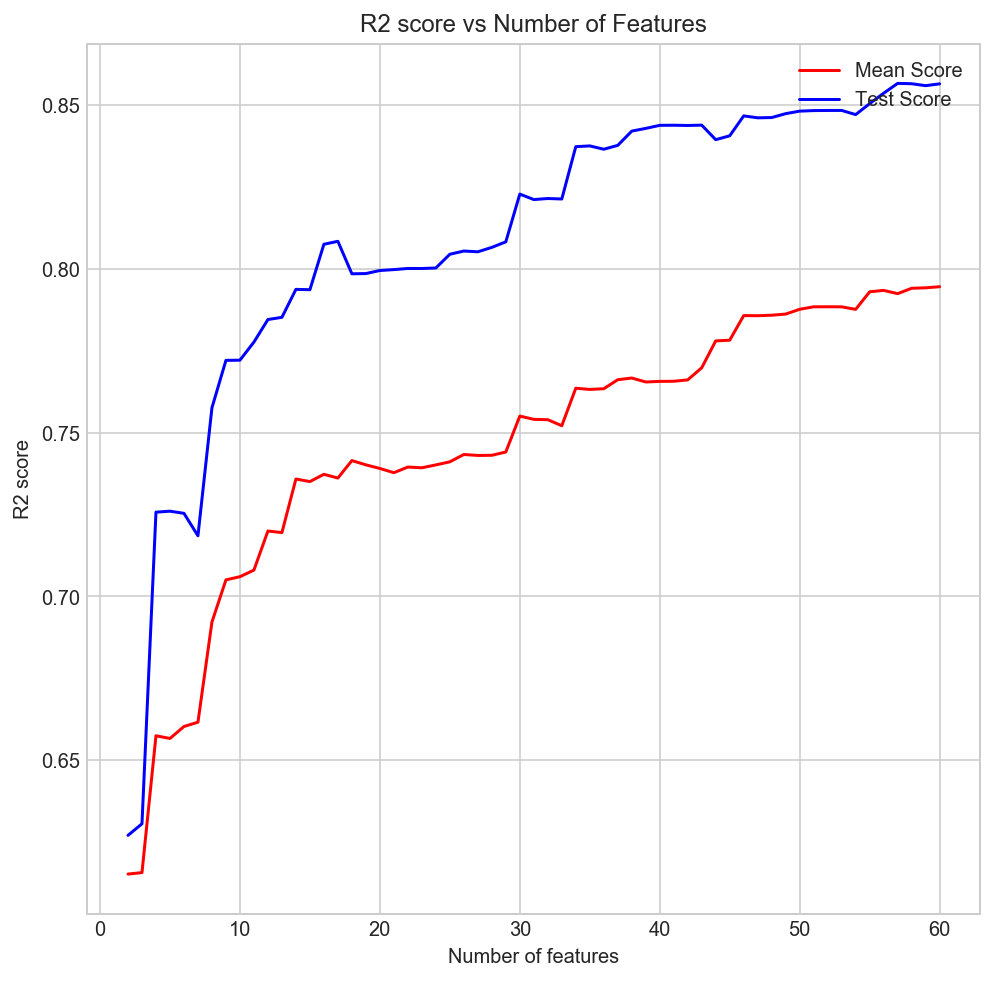

In [79]:
# Plot the R2 of test data vs number of features
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot(n_feat[1:60], mean_score_list[1:60], color='r', label='Mean Score')
ax1.plot(n_feat[1:60], test_score_list[1:60], color='b', label='Test Score')
plt.xlabel('Number of features')
plt.ylabel('R2 score')
plt.title('R2 score vs Number of Features')
plt.legend(loc=1)
plt.show()

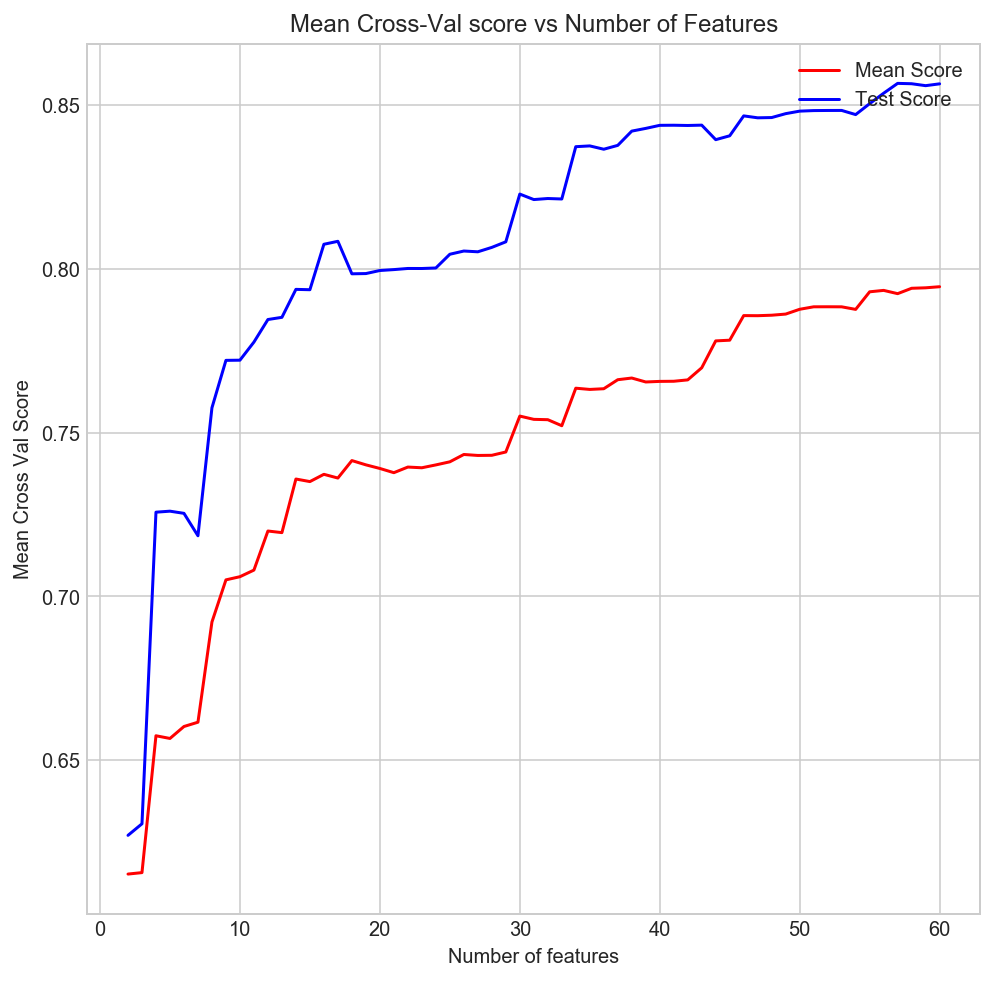

In [80]:
# Plot the mean of cross validation score vs number of features
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot(n_feat[1:60], mean_score_list[1:60], color='r', label='Mean Score')
ax1.plot(n_feat[1:60], test_score_list[1:60], color='b', label='Test Score')
plt.xlabel('Number of features')
plt.ylabel('Mean Cross Val Score')
plt.title('Mean Cross-Val score vs Number of Features')
plt.legend(loc=1)
plt.show()

In [81]:
# Predict the SalePrice with all the features included
lr_all = LinearRegression()
all_scores = cross_val_score(lr_all, X=x_fix_train, y=y_price_train, cv=10, n_jobs=-1, verbose=1)
print('Mean score of model with all features: {}'.format(np.mean(all_scores)))

lr_all.fit(x_fix_train, y_price_train)
print('Model accuracy on test data: {}'.format(lr_all.score(x_fix_test, y_price_test)))

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.8s remaining:    3.1s


Mean score of model with all features: -4.81879730838e+21
Model accuracy on test data: 0.873196559342


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.3s finished


from Chenghan

Try using RFECV to select features

In [82]:
from sklearn.feature_selection import RFECV

rfe_lr = LinearRegression()
rfe1 = RFECV(rfe_lr, step=1, cv=10, n_jobs=-1, verbose=1)
rfe1.fit(x_fix_train, y_price_train)

print('Number of features selected by RFE: {}'.format(rfe1.n_features_))
rfe1_list = x_fix_train.columns[rfe1.support_]
print(rfe1_list)

Number of features selected by RFE: 30
Index([u'LotArea', u'YearBuilt', u'YearRemodAdd', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BedroomAbvGr', u'KitchenAbvGr', u'Fireplaces',
       u'GarageCars', u'MS_2S_New', u'MS_Duplex', u'Bsmt_Fa', u'Bsmt_Gd',
       u'Bsmt_NoBsmt', u'Bsmt_TA', u'Cnd2_PosN', u'Nbrhd_NoRidge',
       u'Nbrhd_NridgHt', u'Nbrhd_StoneBr', u'BlgTy_Duplex', u'BlgTy_Twnhs',
       u'BlgTy_TwnhsE', u'LtShp_IR3', u'MSZ_FV'],
      dtype='object')


In [83]:
# check score of model with the features selected by RFE
score_model(rfe1_list, x_fix_train, y_price_train, x_fix_test, y_price_test)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


(0.7786713171155755, 0.8541223162866869)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

from Chenghan  

Use the model with features selected by RFE to predict the SalePrice of each property.  
Calculate the difference as (Actual SalePrice - Predicted SalePrice).  
Assign this difference as the new target variable to be predicted from the renovate-able features

In [84]:
# Setting up the predictor matrix with the 26 features selected by RFE
x_pred = x_fix_s[rfe1_list]

lr2 = LinearRegression(n_jobs=-1)
lr2.fit(x_pred, y_price)
y_pred = lr2.predict(x_pred)

y_var = y_price - y_pred

In [85]:
# Setting up the train and test data of the new y_var data
y_var_train = y_var[house['YrSold']<2010]
y_var_test = y_var[house['YrSold']==2010]

In [86]:
# Creating a list of the 'renovate-able' characteristics

cols_2 = ['Utilities','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',\
          'MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtCond','BsmtExposure','BsmtFinType1',\
          'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',\
          'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF',\
          'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence','MiscFeature','MiscVal']

In [87]:
# Creating a new dataframe with the renovate-able features
df2 = house[cols_2].copy()

In [88]:
# Create a dictionary of variable and the dummy prefix
renov_dict = {'Utilities':'Ut',
              'RoofStyle':'RfSty',
              'RoofMatl':'RfMat',
              'Exterior1st':'Ext1',
              'ExterQual':'ExtQu',
              'ExterCond':'ExtCnd',
              'Heating':'Heat',
              'HeatingQC':'HeatQC',
              'CentralAir':'CAir',
              'Electrical':'Elec',
              'KitchenQual':'KitQual',
              'Functional':'Func',
              'PavedDrive':'PvDr',
              'Exterior2nd':'Ext2',
              'MasVnrType':'MasVTy',
              'BsmtCond':'BsCnd',
              'BsmtExposure':'BsExp',
              'BsmtFinType1':'BsTy1',
              'BsmtFinType2':'BsTy2',
              'FireplaceQu':'FireQu',
              'GarageFinish':'GrgeFin',
              'GarageQual':'GrgeQu',
              'GarageCond':'GrgeCnd',
              'PoolQC':'Pool',
              'Fence':'Fen',
              'MiscFeature':'MiscFea'}

for key, val in renov_dict.items():
    df2 = pd.concat([df2, pd.get_dummies(df2[key], prefix=val, drop_first=True)], axis=1)
    df2 = df2.drop(columns=key)

In [89]:
# Append y_var to the variables and check for correlation
df2 = pd.concat([df2, y_var], axis=1)

In [91]:
# Calculate the correlation matrix
df2_corr = df2.corr()

# get the correlation values of each variable with Sale Price and sort them in descending order
y_var_corr = df2_corr['SalePrice'].sort_values(ascending=False)
y_var_corr.head()

# there are no features that are correlated to the target variable

SalePrice        1.000000
OverallCond      0.178807
RfMat_WdShngl    0.176144
Func_Typ         0.170046
OverallQual      0.168807
Name: SalePrice, dtype: float64

As there are no variables that are strongly correlated to the variance in price from the first model, a model to predict this variance cannot be built.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [106]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold

# Combine the fixed and renovate-able features into one predictor matrix
df3 = pd.concat([df1, df2], axis=1)

# Convert the SaleCondition column into binary target variable
y3 = [1 if value=='Abnorml' else 0 for value in house['SaleCondition']]
y3 = pd.DataFrame(y3)

# Split into train and test data
y3_train = np.ravel(y3[house['YrSold']<2010].copy())
y3_test = np.ravel(y3[house['YrSold']==2010].copy())

In [107]:
# Standardise the predictor matrix
ss3 = StandardScaler()
x_abnor = ss3.fit_transform(df3)
x_abnor = pd.DataFrame(x_abnor, columns=df3.columns)

# Set up training and test data
x_abnor_train = x_abnor[house['YrSold']<2010].copy()
x_abnor_test = x_abnor[house['YrSold']==2010].copy()

In [108]:
# Use RandomUnderSampler to sample even classes
us = RandomUnderSampler(ratio='majority', random_state=29)
x_train_res, y_train_res = us.fit_sample(x_abnor_train, y3_train)

print('Distribution of class labels before undersampling: {}'.format(Counter(y3_train)))
print('Distribution of class labels after undersampling: {}'.format(Counter(y_train_res)))

# Use LogisticRegressionCV to select features using lasso
logr_cv = LogisticRegressionCV(Cs=100,penalty='l1',cv=5, solver='liblinear', class_weight='balanced', n_jobs=-1, verbose=1)
logr_cv.fit(x_train_res, y_train_res)

Distribution of class labels before undersampling: Counter({0: 1195, 1: 90})
Distribution of class labels after undersampling: Counter({0: 90, 1: 90})


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


LogisticRegressionCV(Cs=100, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=1)

In [109]:
# Identify the features selected
coefs = pd.DataFrame(logr_cv.coef_, columns=x_abnor_train.columns).T
coefs.columns=['lasso_coefs']
coefs_list = coefs[coefs['lasso_coefs']!=0]

In [110]:
# Set up the predictor matrix
x_train_res = pd.DataFrame(x_train_res, columns=x_abnor_train.columns)
x_train_res_new = x_train_res[coefs_list.index].copy()
x_test_new = x_abnor_test[coefs_list.index].copy()

# Train LogisticRegression model
logr_new = LogisticRegression(C=logr_cv.C_[0], penalty='l1', solver='liblinear', class_weight='balanced', verbose=1)
logr_new.fit(x_train_res_new, y_train_res)

print('Score on test data: {}'.format(logr_new.score(x_test_new, y3_test)))

[LibLinear]Score on test data: 0.417142857143
